In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [2]:
file_path1 = 'И124.prn'
file_path2 = 'И4529.prn'
file_path3 = 'РБ122.prn'

In [3]:
df124 = pd.read_csv(file_path1, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
df4529 = pd.read_csv(file_path2, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
df122 = pd.read_csv(file_path3, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)

C:\Users\Алексей\AppData\Local\Temp\ipykernel_22456\1343782749.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df124 = pd.read_csv(file_path1, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
C:\Users\Алексей\AppData\Local\Temp\ipykernel_22456\1343782749.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df4529 = pd.read_csv(file_path2, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)
C:\Users\Алексей\AppData\Local\Temp\ipykernel_22456\1343782749.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df122 = pd.read_csv(file_path3, header=None, names=['Время', 'Амплитуда'], delim_whitespace=True)


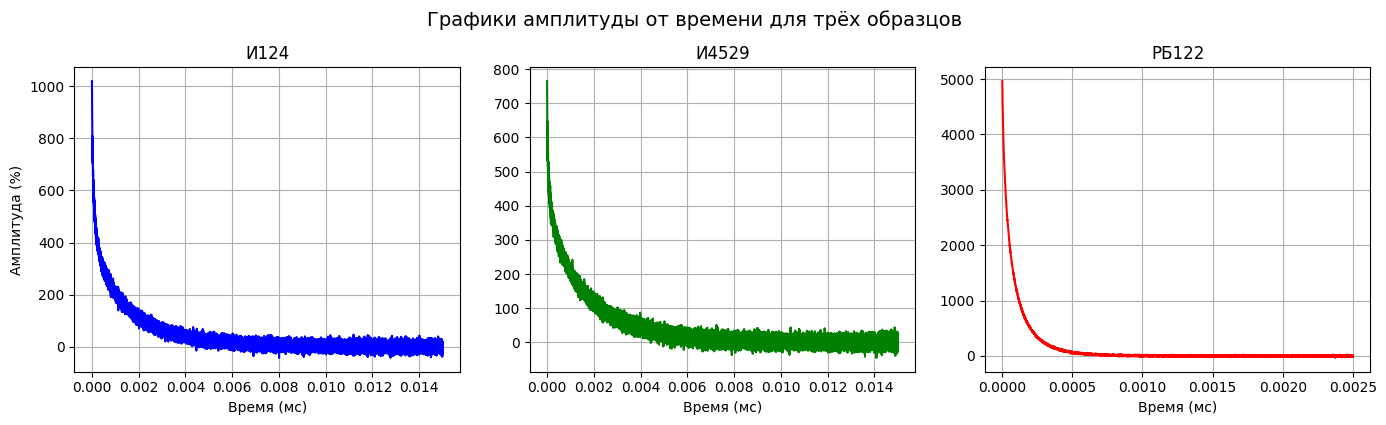

In [5]:
df124['Время'] = df124['Время'] / 1000
df4529['Время'] = df4529['Время'] / 1000
df122['Время'] = df122['Время'] / 1000

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(df124['Время'], df124['Амплитуда'], color='blue')
plt.title('И124')
plt.xlabel('Время (мс)')
plt.ylabel('Амплитуда (%)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(df4529['Время'], df4529['Амплитуда'], color='green')
plt.title('И4529')
plt.xlabel('Время (мс)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(df122['Время'], df122['Амплитуда'], color='red')
plt.title('РБ122')
plt.xlabel('Время (мс)')
plt.grid(True)

plt.tight_layout()
plt.suptitle("Графики амплитуды от времени для трёх образцов", fontsize=14, y=1.05)
plt.show()


In [6]:
T2_values = np.logspace(-1, 3, 56)

In [7]:
t124 = df124['Время'].values.reshape(-1, 1) 
t124_1 = t124.ravel()
amp124 = df124['Амплитуда'].values.reshape(-1, 1)

t4529 = df4529['Время'].values.reshape(-1, 1) 
t4529_1 = t4529.ravel()
amp4529 = df4529['Амплитуда'].values.reshape(-1, 1)

t122 = df122['Время'].values.reshape(-1, 1) 
t122_1 = t122.ravel()
amp122 = df122['Амплитуда'].values.reshape(-1, 1)


In [8]:
matrix1 = np.array([np.exp(-t124_1 / T2) for T2 in T2_values]).T
matrix2 = np.array([np.exp(-t4529_1 / T2) for T2 in T2_values]).T
matrix3 = np.array([np.exp(-t122_1 / T2) for T2 in T2_values]).T

In [9]:
models = {
    'LR': LinearRegression(positive=True),
    'Ridge': Ridge(positive=True, max_iter=3000),
    'Lasso': Lasso(positive=True, max_iter=3000),
    'ElasticNet': ElasticNet(positive=True, max_iter=3000)
}

params = {
    'LR': {},  # LinearRegression не требует параметров
    'Ridge': {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10]},
    'Lasso': {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10]},
    'ElasticNet': {
        'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 2, 5, 10],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}


In [10]:


def fit_best_model(X, y, model_dict, param_dict):
    results = []
    for name, model in model_dict.items():
        grid = GridSearchCV(model, param_dict[name], cv=5)
        grid.fit(X, y.ravel())
        results.append((grid.best_estimator_, grid.best_score_))
    
    best_model = max(results, key=lambda x: x[1])[0]

    return best_model, results



In [11]:
best_model_124, results_124 = fit_best_model(matrix1, amp124, models, params)

best_model_4529, results_4529 = fit_best_model(matrix2, amp4529, models, params)

best_model_122, results_122 = fit_best_model(matrix3, amp122, models, params)


In [12]:
print("Лучшая модель для И124:", best_model_124)
print("Лучшая модель для И4529:", best_model_4529)
print("Лучшая модель для РБ122:", best_model_122)


Лучшая модель для И124: ElasticNet(alpha=0.01, l1_ratio=0.3, max_iter=3000, positive=True)
Лучшая модель для И4529: ElasticNet(alpha=0.01, max_iter=3000, positive=True)
Лучшая модель для РБ122: Ridge(alpha=1, max_iter=3000, positive=True)


In [17]:
def plot_amplitude_fit(ax, t, amp, model, X, sample_name):
    ax.plot(t, amp, label='Реальные данные', color='blue')
    ax.plot(t, model.predict(X), label='Предсказание модели', color='red', linestyle='--')
    ax.set_xlabel('Время (мс)')
    ax.set_ylabel('Амплитуда (%)')
    ax.set_title(f'Релаксационная кривая: {sample_name}')
    ax.legend()
    ax.grid(True)



In [18]:
def plot_T2_spectra(ax, results, T2_values, sample_name):
    for estimator, _ in results:
        coefs = estimator.coef_.ravel()
        ax.plot(T2_values, coefs, label=f'{estimator.__class__.__name__}')
    ax.set_xscale('log')
    ax.set_xlabel('T2 (мс)')
    ax.set_ylabel('Коэффициенты B(T2)')
    ax.set_title(f'Спектры T2: {sample_name}')
    ax.legend()
    ax.grid(True)


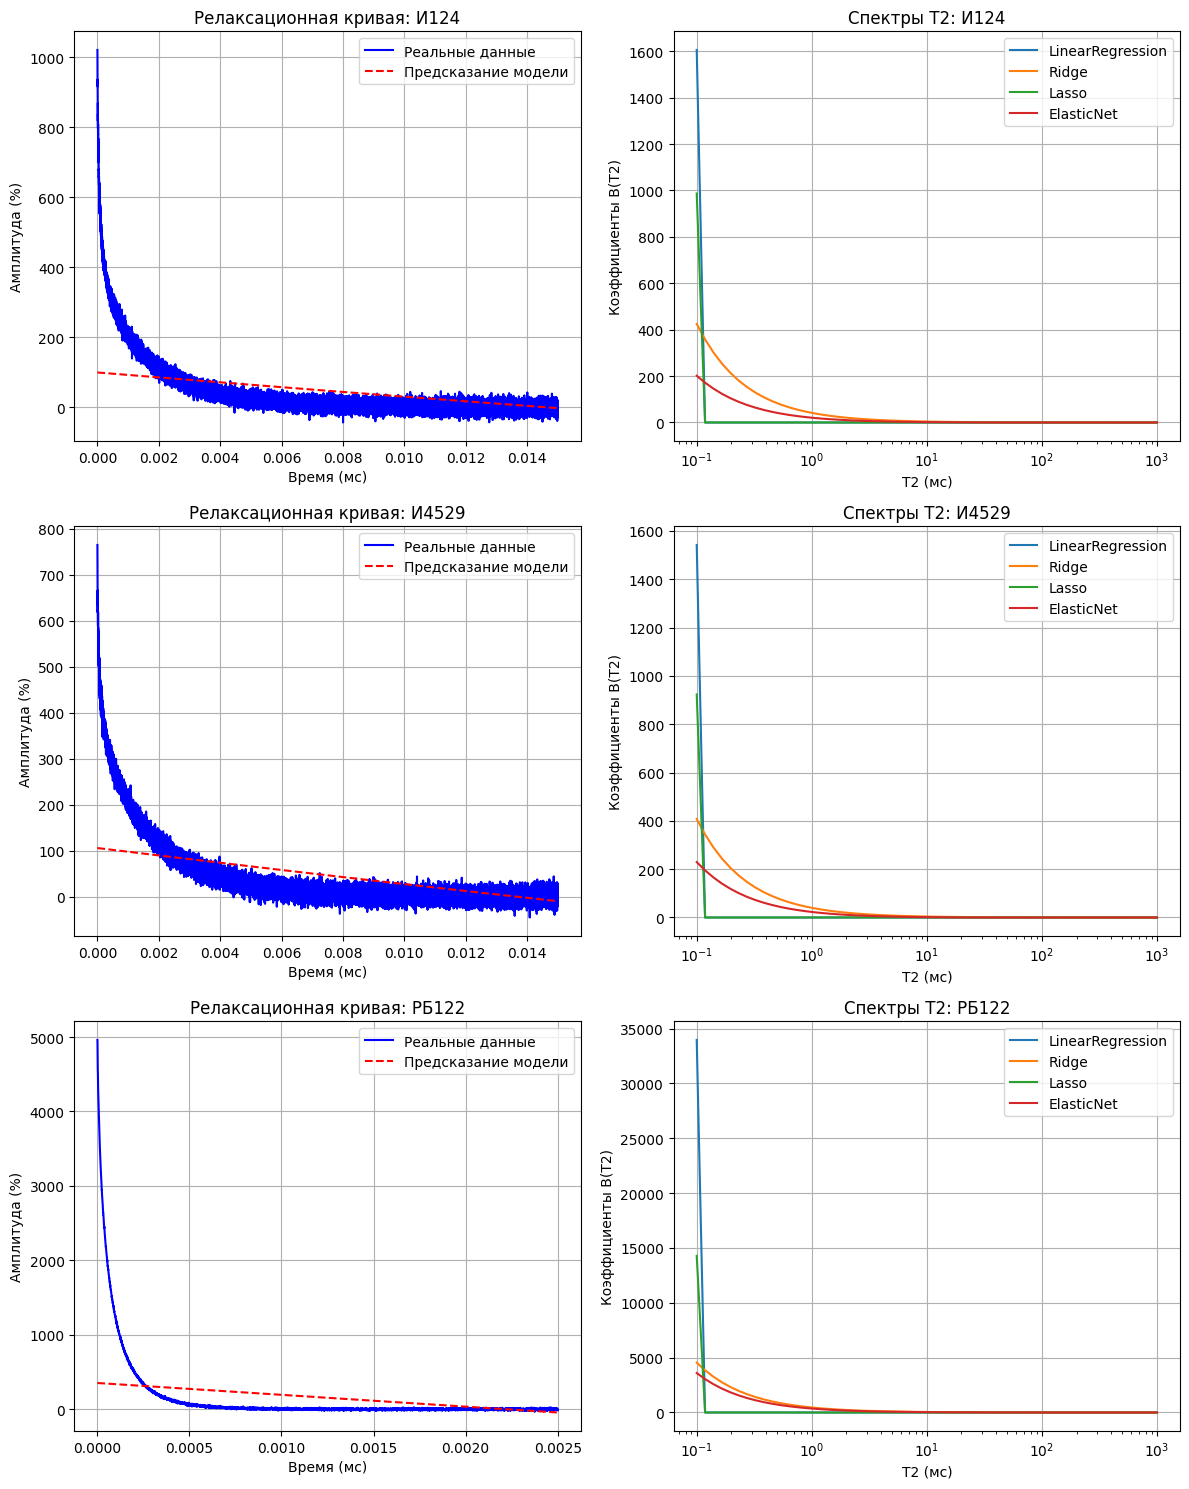

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
axes = axes.flatten() 


plot_amplitude_fit(axes[0], t124_1, amp124, best_model_124, matrix1, 'И124')   
plot_T2_spectra(axes[1], results_124, T2_values, 'И124')                  


plot_amplitude_fit(axes[2], t4529_1, amp4529, best_model_4529, matrix2, 'И4529') 
plot_T2_spectra(axes[3], results_4529, T2_values, 'И4529')                     


plot_amplitude_fit(axes[4], t122_1, amp122, best_model_122, matrix3, 'РБ122')    
plot_T2_spectra(axes[5], results_122, T2_values, 'РБ122')                     
plt.tight_layout()  
plt.show()